# Draft workbook to test plotting functions

Plots to do:
- Basic TS plot
- Seasonal plot + polar!
- Seasonal subseries plot (also box?)
- Scatterplot
- ACF plots

## Imports and setups

In [1]:
import sys
sys.path.append('../')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from scipy.stats import norm
%matplotlib inline  

from gtime.preprocessing import TimeSeriesPreparation
from gtime.compose import FeatureCreation
# from gtime.time_series_models import (
#     NaiveForecastModel, 
#     SeasonalNaiveForecastModel, 
#     AverageForecastModel, 
#     DriftForecastModel,
# )

## Ploting functions

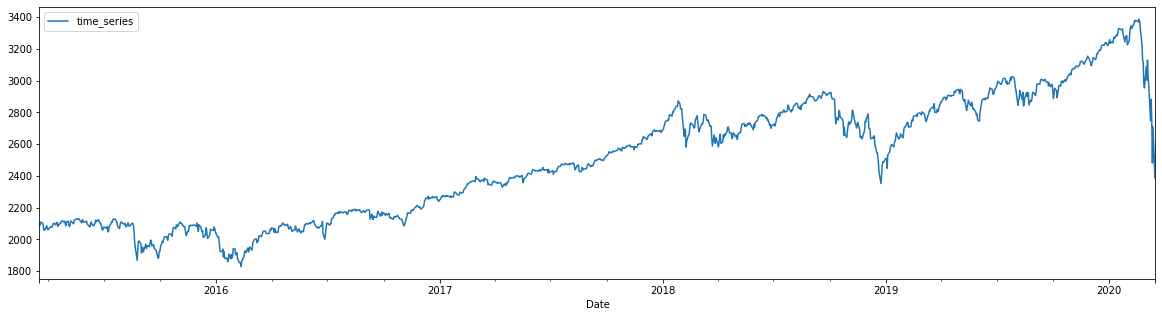

In [114]:
df_sp = pd.read_csv('https://storage.googleapis.com/l2f-open-models/giotto-time/examples/data/^GSPC.csv')
df_close = df_sp.set_index('Date')['Close']
df_close.index = pd.to_datetime(df_close.index)
time_series_preparation = TimeSeriesPreparation()
period_index_time_series = time_series_preparation.transform(df_close)
period_index_time_series.plot(figsize=(20, 5))
plt.show()

## Time series setup

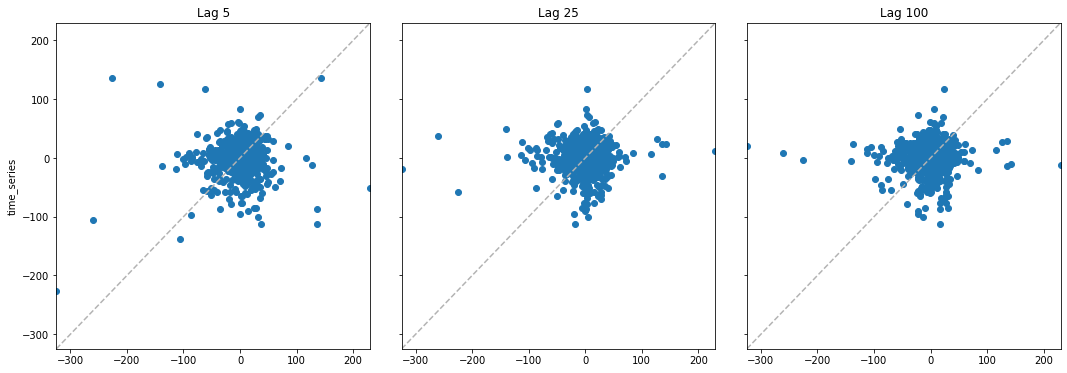

In [84]:
def lagplot(df : pd.DataFrame, lags):
    
    if isinstance(lags, int):
        lags = list(range(1, lags+1))
    
    fig, ax = plt.subplots(df.shape[1], len(lags), 
                       sharey=True, sharex=True, figsize=(18, 6), squeeze=False, 
                       gridspec_kw={'wspace':0.1})
    i = 0

    for col_name, col in df.iteritems():
        j = 0
        x_lim = [df.iloc[:, i].min(), df.iloc[:, i].max()]
        for l in lags:
            axes = ax[i, j]
            axes.scatter(df.iloc[l:, i], df.iloc[:-l, i])
            axes.set(title='Lag ' + str(l), ylabel=col_name)
            axes.plot(x_lim, x_lim, ls="--", c=".7")
            axes.set(xlim=x_lim, ylim=x_lim)
            axes.label_outer()
            j += 1
        i += 1
    return axes
    
a = lagplot(period_index_time_series.diff(), [5, 25, 100])
a

In [86]:
plt.axes

<function matplotlib.pyplot.axes(arg=None, **kwargs)>

In [102]:
df_close.iloc[:15]

Date
2015-03-18    2099.500000
2015-03-19    2089.270020
2015-03-20    2108.100098
2015-03-23    2104.419922
2015-03-24    2091.500000
2015-03-25    2061.050049
2015-03-26    2056.149902
2015-03-27    2061.020020
2015-03-30    2086.239990
2015-03-31    2067.889893
2015-04-01    2059.689941
2015-04-02    2066.959961
2015-04-06    2080.620117
2015-04-07    2076.330078
2015-04-08    2081.899902
Name: Close, dtype: float64

In [104]:

def pacf(x, max_lags=1):
    n = len(x)
    x = (x - np.mean(x)) / (np.std(x) * np.sqrt(n))
    pacf = np.array([yw(x, i)[-1] for i in range(min(n, max_lags) + 1)])
    return pacf

pacf(np.array(df_close.iloc[:15]), 15)

array([ 1.        ,  0.58605525, -0.20541852, -0.15089993,  0.21536218,
       -0.30921943, -0.01974469, -0.20007992,  0.07772186, -0.19612716,
       -0.03519717,  0.13384736, -0.20629998,  0.00515652, -0.02735731,
       -0.0643404 ])

In [107]:
df_close.values.flatten()

array([2099.5     , 2089.27002 , 2108.100098, ..., 2711.02002 ,
       2386.129883, 2529.189941])

In [6]:
def autocorr(x, lag):
    x_lag = x[lag:]
    x_1 = x[:-lag]
    cov = np.cov(x_1, x_lag)
    corr = cov[0, 1] / np.sqrt(cov[1, 1] * cov[0, 0])
    return corr

autocorr(np.array([1, 2, 3, 4]), 1)

[[1. 1.]
 [1. 1.]]


1.0

In [94]:
from scipy.linalg import toeplitz

def yw(x: np.array, order=1, unbiased=False):
    
    if order == 0:
        return np.array([1.0])
    
    n = len(x)
    r = np.zeros(order+1, np.float64)
    r[0] = (x ** 2).sum() / n
    for k in range(1, order+1):
        r[k] = (x[0:-k] * x[k:]).sum() / (n - k * unbiased)
    R = toeplitz(r[:-1])
    rho = np.linalg.solve(R, r[1:])   
    return rho


def pacf(x, max_lags=1):
    
    n = len(x)
    x = (x - np.mean(x)) / (np.std(x) * np.sqrt(n))
    pacf = [1.]
    for k in range(1, max_lags + 1):
        pacf.append(yw(x, k)[-1])
    return np.array(pacf)


pacf(np.array([1.0, 2, 3, 4]), 3)


array([ 1.        ,  0.25      , -0.38666667, -0.31270903])

In [73]:
def acf_plot(df: pd.DataFrame, max_lags: int = 10, ci: float = 0.05, partial=False, ax=None):
    x = np.squeeze(df.values)
    if partial:
        acfs = pacf(x, max_lags)
    else:
        acfs = acf(x, max_lags)
    print(acfs)
    print(range(1, max_lags + 1))
    if ax is None:
        ax = plt.subplot(111)
    ax.bar(range(1, max_lags + 1), acfs[1:], 0.05)
    ci = norm.ppf(1 - ci / 2) / np.sqrt(len(x))
    ax.axhline(ci, color='gray', linestyle='--')
    ax.axhline(0.0, color='black', linestyle='-')
    ax.axhline(-ci, color='gray', linestyle='--')

    return ax

[ 1.          0.74853224 -0.11813386  0.12299487 -0.00175116 -0.14948777
  0.01561861 -0.18265487  0.07874236 -0.06244437 -0.05743793  0.06906062
  0.0134672  -0.05180063  0.06823242  0.02629579]
range(1, 16)


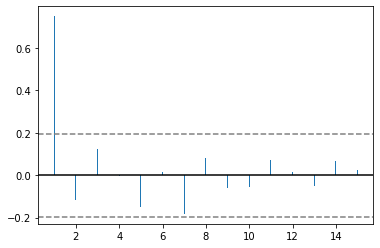

In [74]:
acf_plot(df_close.iloc[:100], max_lags=15, partial=True);

In [66]:
acf(df_close.iloc[:100], max_lags=10)

array([ 1.        ,  0.74853224,  0.50835712,  0.39037324,  0.3113311 ,
        0.17684978,  0.0815524 , -0.03562858, -0.08027753, -0.11105834,
       -0.1508139 ])

In [57]:
x = [1, 2, 3, 4]
x[1:-1]

[2, 3]

In [65]:
def acf(x, max_lags=None):
    n = len(x)
    if max_lags is None or max_lags > n:
        max_lags = n    
    x = (x - np.mean(x)) / (np.std(x) * np.sqrt(n))

    if max_lags == n:
        result = np.correlate(x, x, mode='full')[-n:]
    else:
        result = np.correlate(x, x, mode='full')[-n:-n + max_lags + 1]
    return result

acf(np.array([1, 1, 1, 1]), max_lags=5)

/Users/semyonburyachenko/Documents/Upwork/Giotto/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


array([nan, nan, nan, nan])

In [127]:
# helper functions

def seasonal_split(df : pd.DataFrame, cycle='year', freq=None, agg='mean'):
    
    if freq is None:
        freq = df.index.freqstr
    df = df.resample(freq).agg(agg)
    
    if isinstance(cycle, str):
        if cycle == 'year':
            df['_Series'] = df.index.start_time.year
            if freq == 'D':
                df['_Season'] = df.index.dayofyear
#             elif freq in ['W-SUN', 'W']:
#                 df['_Season'] = df.index.start_time.weekofyear
            elif freq == 'M':
                df['_Season'] = df.index.month
            elif freq in ['Q', 'Q-DEC']:
                df['_Season'] = df.index.quarter
            else:
                df['_Season'] = df.resample('Y').apply(lambda x: pd.Series(np.arange(1, len(x) + 1))).values
                
        elif cycle == 'quarter':
            df['_Series'] = list(map(lambda x: '_'.join([str(x.year), str(x.quarter)]), df.index))
            df['_Season'] = df.resample('Q').apply(lambda x: pd.Series(np.arange(1, len(x) + 1))).values
            
        elif cycle == 'month':
            df['_Series'] = list(map(lambda x: '_'.join([str(x.year), str(x.month)]), df.index))
            if freq == 'D':
                df['_Season'] = df.index.day
            else:
                df['_Season'] = df.resample('M').apply(lambda x: pd.Series(np.arange(1, len(x) + 1))).values
                
        elif cycle == 'week':
            df['_Series'] = list(map(lambda x: '_'.join([str(x.year), str(x.weekofyear)]), df.index))
            if freq == 'D':
                df['_Season'] = df.index.day
            else:
                df['_Season'] = df.resample('W').apply(lambda x: pd.Series(np.arange(1, len(x) + 1))).values
        else:
            raise ValueError("Incorrect cycle period name")    
    else:
        df['_Series'] = df.resample
        s = []
        for i, j in period_index_time_series.resample(freq):
            s += [i.__str__()] * len(j)
        df['_Season'] = s    
            
    return df.set_index(['_Series', '_Season']).unstack(level=0)
    
seasonal_split(period_index_time_series, 'year', freq='M')

time_series                                                      \
_Series         2015         2016         2017         2018         2019   
_Season                                                                    
1                NaN  1918.597887  2275.115979  2789.803816  2607.389997   
2                NaN  1904.418494  2329.910542  2705.155248  2754.864206   
3        2082.513989  2021.954090  2366.822170  2702.773821  2803.983794   
4        2094.862840  2075.535232  2359.309455  2653.625209  2903.799979   
5        2111.943518  2065.550479  2395.345881  2701.493619  2854.705910   
6        2099.283658  2083.891368  2433.985451  2754.352888  2890.165979   
7        2094.143627  2148.901978  2454.102502  2793.643357  2996.113636   
8        2039.866205  2177.482167  2456.223070  2857.820429  2897.450451   
9        1944.402384  2157.690965  2492.841040  2901.500514  2982.156006   
10       2024.812716  2143.020938  2556.997270  2785.464780  2977.675198   
11       2080.616504  2164.985689  2593.605736  2723.231422  3104.904492   
12       2054.079562  2246.629046  2664.340527  2567.307386  3176.749512   

                      
_Series         2020  
_Season               
1        3278.202858  
2        3277.314183  
3        2808.098328  
4                NaN  
5                NaN  
6                NaN  
7                NaN  
8                NaN  
9                NaN  
10               NaN  
11               NaN  
12               NaN

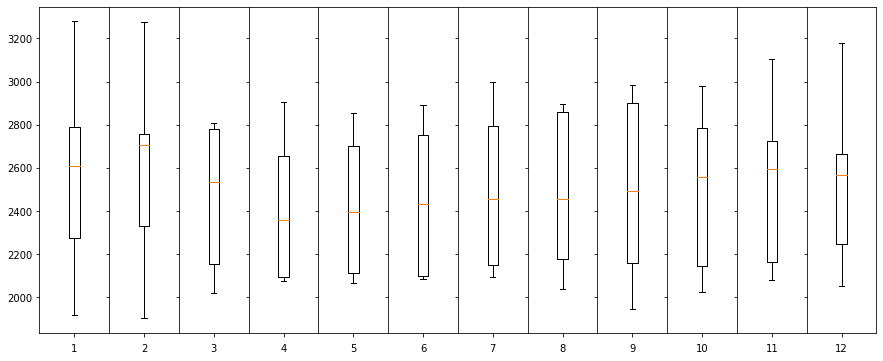

In [13]:

def subplots(df: pd.DataFrame, cycle, freq=None, agg='mean', box=False):
    ss = seasonal_split(df, cycle, freq, agg)
    fig, ax = plt.subplots(ss.columns.levshape[0], ss.shape[0], 
                           sharey=True, figsize=(15, 6), squeeze=False, 
                           gridspec_kw={'wspace':0})
    i = 0
    for _, table in ss.groupby(level=0, axis=1):
        j = 0
        for _, col in table.iterrows():
            axes = ax[i, j]
            if box:
                axes.boxplot(col.dropna())
            else:
                col.plot(ax=axes)
                mean = col.mean()
                axes.axhline(mean, color='gray', linestyle='--')
            axes.set(xlabel=col.name)
            axes.set_xticklabels([])
            j += 1
        i += 1
    plt.show()

subplots(period_index_time_series, 'year', 'M', box=True)    

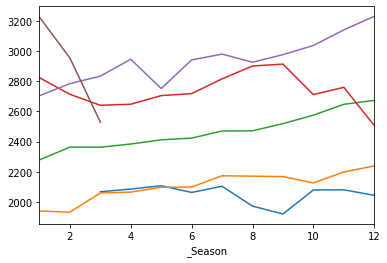

In [14]:
def plot_fun(df, ax=None):
    if ax is None:
        ax = df.plot(legend=False)
    else:
        df.plot(ax=ax, legend=False)
    return ax

def basic_ts(df, ax=None):
    ax = plot_fun(df, ax)
    return ax

def polar_ts(df, ax=None):
    df = df.append(df.iloc[0])
    if ax is None:
        ax = plt.subplot(111, projection='polar')
    else:
        if ax.get_projection()
    angles = [x * 360 / (len(df) - 1) for x in range(len(df))]
    theta = [x / 360 * 2 * np.pi for x in angles]
    for col in df.columns:
        plt.polar(theta, df[col], scalex=False)
    ax.set_thetagrids(angles=angles)
    ax.set_xticklabels(df.index)
    return ax

def season_ts(df: pd.DataFrame, cycle, freq=None, polar=False, ax=None):
    df_seas = seasonal_split(df, cycle, freq)
    if polar:
        ax = polar_ts(df_seas, ax=ax)
    else:
        ax = basic_ts(df_seas, ax=ax)
#         if isinstance(cycle, str):
#             ax.set_xlabel(str(freq) + ' of ' + cycle)
    return ax

season_ts(period_index_time_series.resample('M').last().fillna(method='ffill'), 'year', polar=False)

## Tests

In [109]:
returns = period_index_time_series.diff() / period_index_time_series

In [112]:
returns.dropna()

,time_series
Date,
2019-01-03,-0.025385
2019-01-04,0.033196
2019-01-07,0.006962
2019-01-08,0.009602
2019-01-09,0.004081
...,...
2019-12-24,-0.000195
2019-12-26,0.005102
2019-12-27,0.000034


[ 1.         -0.09111496 -0.05676018  0.00440101  0.00738162 -0.06348921
 -0.08469792  0.14959507 -0.01581047  0.08674831 -0.03759476]
range(1, 11)


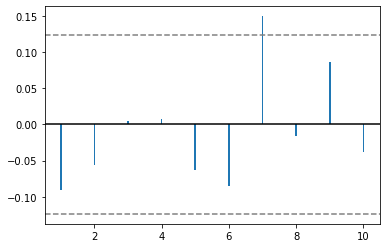

In [113]:
acf_plot(returns.dropna())

/Users/semyonburyachenko/Documents/Upwork/Giotto/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/semyonburyachenko/Documents/Upwork/Giotto/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/semyonburyachenko/Documents/Upwork/Giotto/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start 

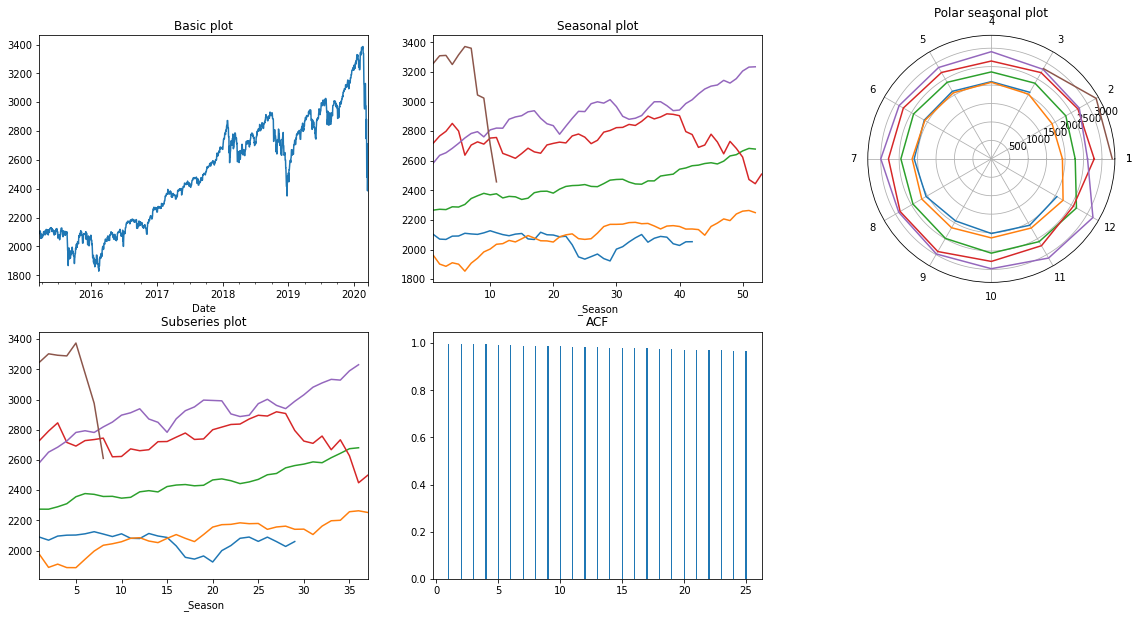

In [1161]:
# Show
ddf = period_index_time_series.resample('D').fillna(method='ffill')
fig = plt.figure(figsize=(20, 10))
a = fig.add_subplot(231, title='Basic plot')
basic_ts(ddf, ax=a)
b = fig.add_subplot(232, title='Seasonal plot')
season_ts(ddf, 'year', freq='W', ax=b)
c = fig.add_subplot(233, projection='polar')
season_ts(ddf, 'year', freq='M', ax=c, polar=True)
c.set_title('Polar seasonal plot')
d = fig.add_subplot(234, title='Subseries plot')
season_ts(ddf, 'year', pd.Timedelta(10, 'D'), ax=d)

# subplots(period_index_time_series, 'year', 'M', ax=d) 
f = fig.add_subplot(235, title='ACF')
y = acf(ddf, max_lag=25)
f.bar(y.index, np.squeeze(y.values), 0.1)

plt.show()